# Deconvoluzione di una immagine

In questo esercizio si vuole ridurre (idealmente rimuovere) la sfocatura da una immagine (_deblur_) tramite deconvoluzione della _point spread function_ (PSF), ed in particolare utilizzando la trasformata rapida di Fourier.

## Introduzione

Una immagine fotografica viene registrata in un computer tramite una matrice di vettori le cui componenti sono numeri interi che rappresentano i livelli di intensità dei tre colori primari in quel punto o _pixel_ (ci si riferisce a questo genere di rappresentazioni delle immagini come grafica _raster_).

In questo senso è possibile associare una immagine in scala di grigi ad una matrice dove il massimo, eventualmente normalizzato ad 1, rappresenta il nero, il minimo il bianco ed i valori intermedi i vari livelli di annerimento (o viceversa, ottenendo il negativo della precedente).

In generale si definisce **point spread function**, ovvero funzione di dispersione del punto, la risposta di un rivelatore ad un impulso puntiforme, che nell'esempio in considerazione della fotografia digitale è l'immagine di una sorgente puntiforme registrata dal sensore sotto forma di matrice.

Dal principio di sovrapposizione la matrice delle intensità (il segnale) sarà la convoluzione della risposta nel caso ideale (con PSF a delta di Dirac) e della PSF del sistema in considerazione. Si vuole pertanto riottenere la matrice delle intensità del caso ideale tramite deconvoluzione della PSF.

Come è noto le operazioni di convoluzione nello spazio di Fourier corrispondono ad operazioni algebriche, infatti si mostra semplicemente che se $f(x,y)$ è la risposta nel caso ideale, $k(x,y)$ è la PSF e g(x,y) la risposta del caso reale allora vale

\begin{equation}
\tilde{f}(\omega,\rho) = \frac{\tilde{g}(\omega,\rho)}{\tilde{k}(\omega,\rho)}
\end{equation}

Pertanto tramite trasformata di fourier inversa è possibile ottenere la funzione di intensità desiderata. Nel caso discreto le precedenti relazioni sono ancora valide e a meno di un fattore (ininfluente) la matrice delle intensità cercata è la trasformata inversa di $\dfrac{\tilde{g_{ij}}}{\tilde{k_{ij}}}$

Benchè si osservi che **la PSF non è nota a priori**, l'ansatz di una PSF di tipo gaussiano è ragionevole per molti sistemi fisici. Rimane a questo punto il problema della determinazione della larghezza ottimale della gaussiana, tuttavia in questo esercizio questo valore é dato e vale $\sigma=25$.

## Operazioni preliminari

Vengono preliminarmente importati alcuni moduli, fra questi in particolare `urllib.request` contiene la funzione `urlretrieve` necessaria al download dei file (__nota__: per Python 2 non è necessario accedere al sottomodulo `request`). Inoltre vengono effettuate le configurazioni necessarie a visualizzare i grafici direttamente nel quaderno.

In [1]:
# Importing modules
from urllib.request import urlretrieve as download
import numpy as np
import numpy.fft as nft
import matplotlib.pyplot as plt

# Display configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Viene salvata una copia locale dei file di dati, quindi viene caricata in memoria e letta come matrice tramite la funzione `loadtxt()`

In [2]:
download("http://www-personal.umich.edu/~mejn/cp/data/blur.txt","data/blur.txt")

('data/blur.txt', <http.client.HTTPMessage at 0x7fbc018e5f60>)

In [3]:
imgdata = np.loadtxt("data/blur.txt")

## Deconvoluzione tramite trasformata di Fuorier

A questo punto è possibile visualizzare semplicemente l'immagine tramite la funzione `imshow()`, si osserva che per una corretta visualizzazione occorre specificare la mappa di colori `cmap='Greys_r'` (mentre `cmap='Greys'` produce il negativo della precedente).

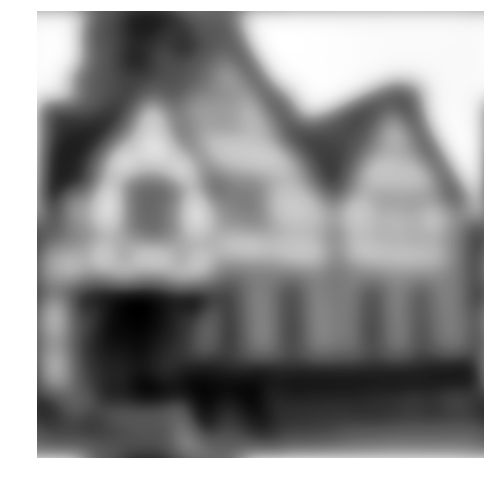

In [4]:
plt.axis("off")
plt.imshow(imgdata,cmap='Greys_r')

Si calcola ora la PSF tramite la funzione `gaussian(sample,sigma)` (il primo argomento ha l'unico scopo di passare le dimensioni della matrice di uscita). Si osserva che grazie alla funzione `meshgrid` del modulo NumPy è possibile implementare quest'ultima conservando la notazione vettoriale.

Inoltre si è tenuto conto delle opportune proprietà di simmetria derivanti dalla posizione dell'origine, dalla orientazione degli assi e dalla periodicità (necessaria per trafromare secondo Fourier).

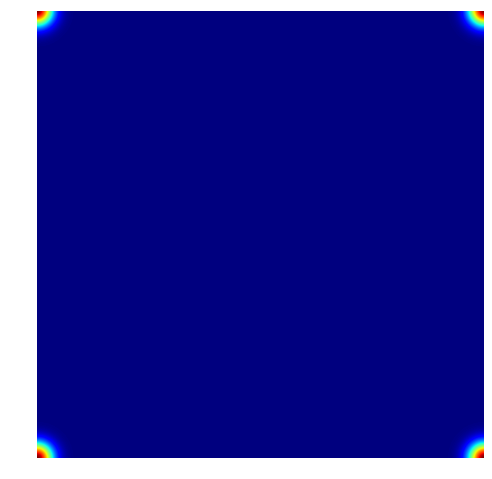

In [5]:
def gaussian(sample,sigma):
    nx, ny = sample.shape

    x = nx/2.0 - abs(np.arange(nx)-nx/2.0)
    y = ny/2.0 - abs(np.arange(ny)-ny/2.0)
    
    xx,yy = np.meshgrid(x,y)
    
    return np.exp(-0.5*(xx**2+yy**2)/sigma**2)
    
gaussPSF = np.empty_like(imgdata)
gaussPSF = gaussian(gaussPSF,25)
plt.axis("off")
plt.imshow(gaussPSF)

Ora è possibile calcolare le trasformate di Fourier tramite il sottomodulo `numpy.fft`. Si osserva che nel calcolo delle trasformate reali le funzioni di questo sottomodulo fanno un uso efficiente della memoria e (anche se non mostrato esplicitamente) le matrici intermedie, che contengono le trasformate, hanno dimensione ridotta (per matrici di partenza di dimensioni $n\times m$ le trasformate sono di dimensione $n \times (\dfrac{1}{2} m + 1)$ per $m$ pari e $n \times \dfrac{1}{2} (m + 1)$ per $m$ dispari).

Si osserva che la trasformata della PSF assume valori molto piccoli lontano dall'origine, pertanto una implementazione diretta dell'algoritmo comporta errori di overflow (divisione per zero). Si ovvia a questo problema imponendo un cutoff `eps` uguale a $10^{-3}$.

Questo fatto corrisponde ha la seguente interpretazione. La funzione $b(x,y)$, inversa della PSF nel senso delle convoluzioni, ovvero definita dalla seguente (con un abuso di notazione nelle seguenti si intende $x,y,z \in \mathbb{R}^2$)

\begin{equation}
\int \mathrm{d}^2 z \; b(x-z) k(z-y) = \delta^{(2)}(x-y)
\end{equation}

in modo che 

\begin{equation}
\int \mathrm{d}^2 z \; b(x-z) g(z) = \int \mathrm{d}^2 z \; \mathrm{d}^2 y \; b(x-z) k(z-y) f(y) = \int \mathrm{d}^2 y \; \delta^{(2)}(x-y) f(y) = f(x)
\end{equation}

assume valori grandi lontano dall'origine. Pertanto, in assenza del cutoff `eps`, si sta tenendo conto di una forte correlazione fra punti lontani.

In [6]:
imgdataFT = nft.rfft2(imgdata)
gaussPSFFT = nft.rfft2(gaussPSF)

eps = 1e-3

imgDeblurFT = imgdataFT/np.maximum(eps,gaussPSFFT)
imgDeblur = nft.irfft2(imgDeblurFT)

A questo punto è possibile visualizzare il risultato. Si osserva che riducendo il valore di `eps` si vede come l'immagine diventi progressivamente meno sfocata ma più rumorosa, fino a diventare inintellegibile.

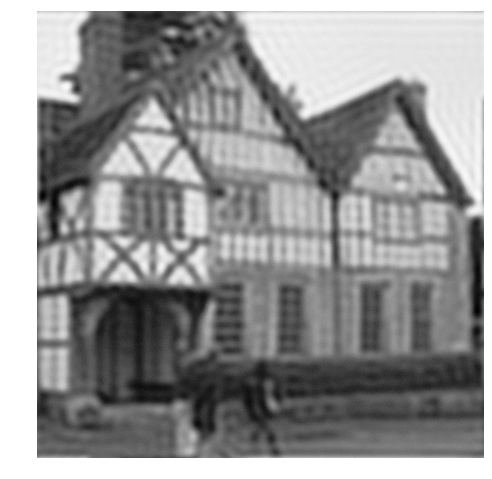

In [7]:
plt.axis("off")
plt.imshow(imgDeblur,cmap='Greys_r')